<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day                     366 non-null    int64  
 1   pressure                366 non-null    float64
 2   maxtemp                 366 non-null    float64
 3   temparature             366 non-null    float64
 4   mintemp                 366 non-null    float64
 5   dewpoint                366 non-null    float64
 6   humidity                366 non-null    int64  
 7   cloud                   366 non-null    int64  
 8   rainfall                366 non-null    object 
 9   sunshine                366 non-null    float64
 10           winddirection  365 non-null    float64
 11  windspeed               365 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB
the null values are: 0


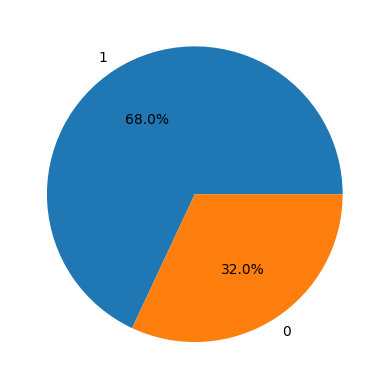

Correlation with the target variable 'rainfall':
rainfall         1.000000
cloud            0.625766
humidity         0.489623
windspeed        0.154389
dewpoint         0.139916
day              0.010339
mintemp         -0.007697
winddirection   -0.013206
temparature     -0.037360
pressure        -0.089275
maxtemp         -0.101003
sunshine        -0.552519
Name: rainfall, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   maxtemp    366 non-null    float64
 1   dewpoint   366 non-null    float64
 2   humidity   366 non-null    int64  
 3   cloud      366 non-null    int64  
 4   rainfall   366 non-null    int64  
 5   sunshine   366 non-null    float64
 6   windspeed  366 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 20.1 KB


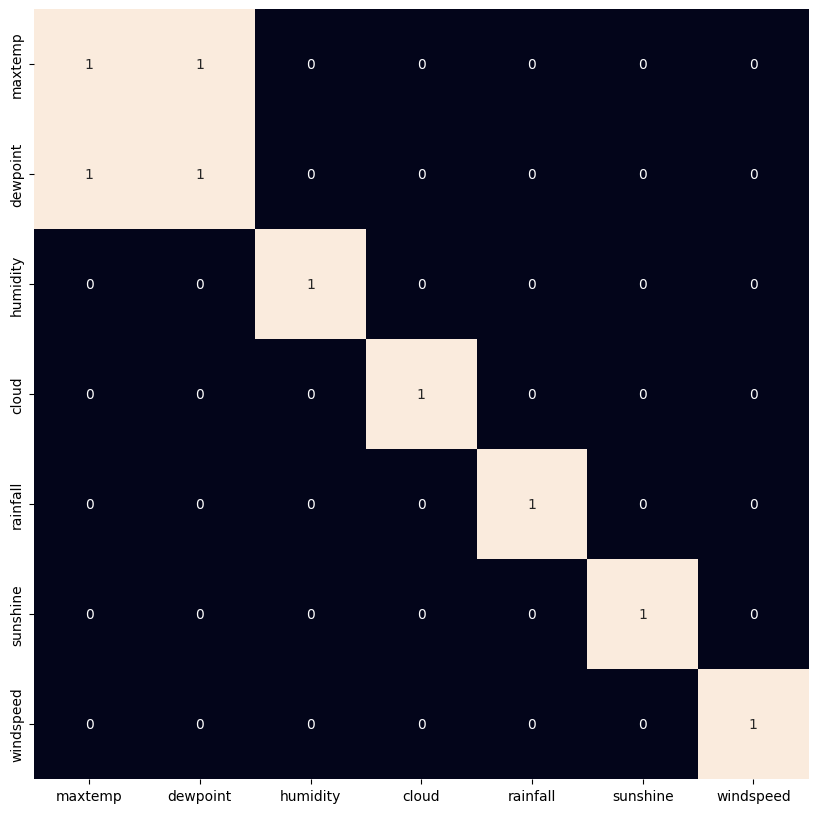

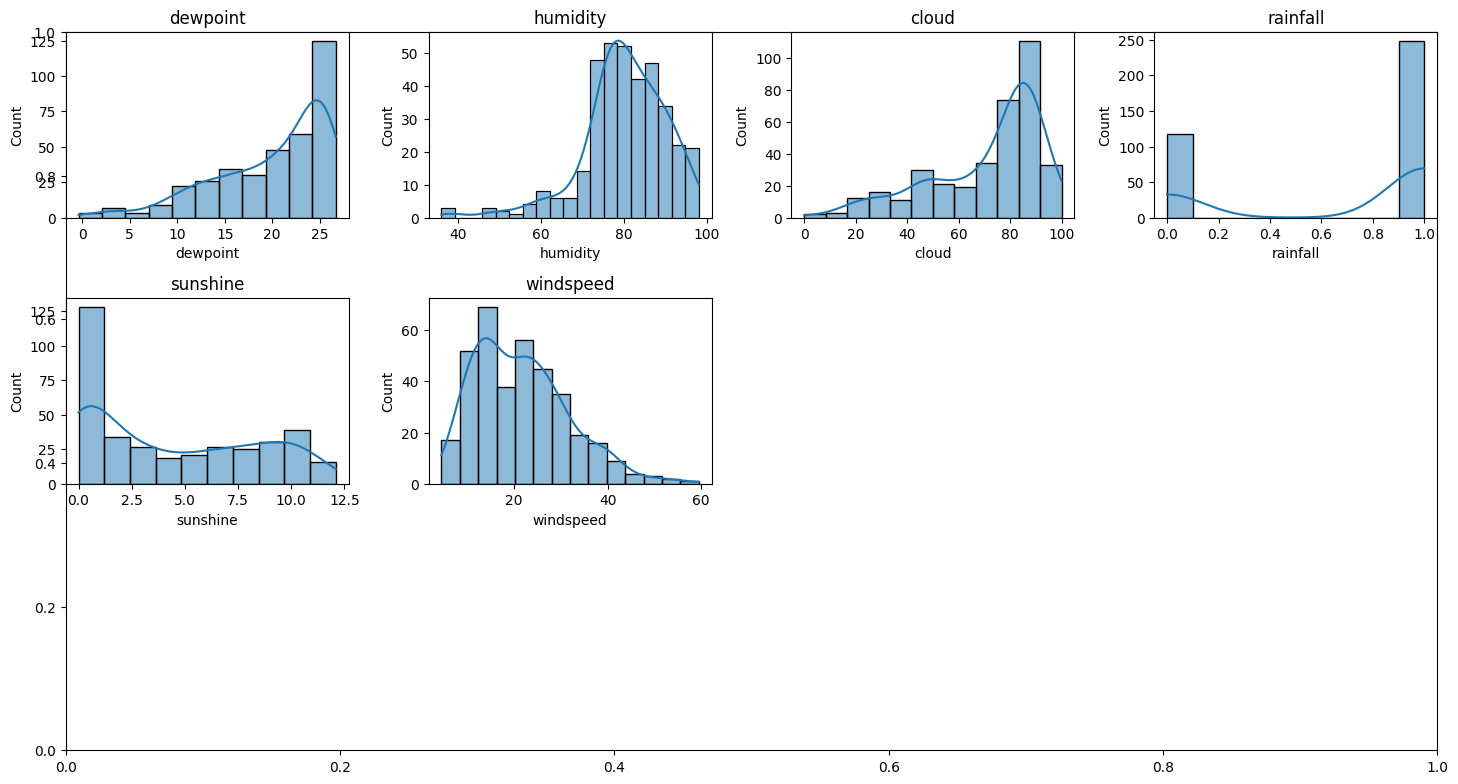

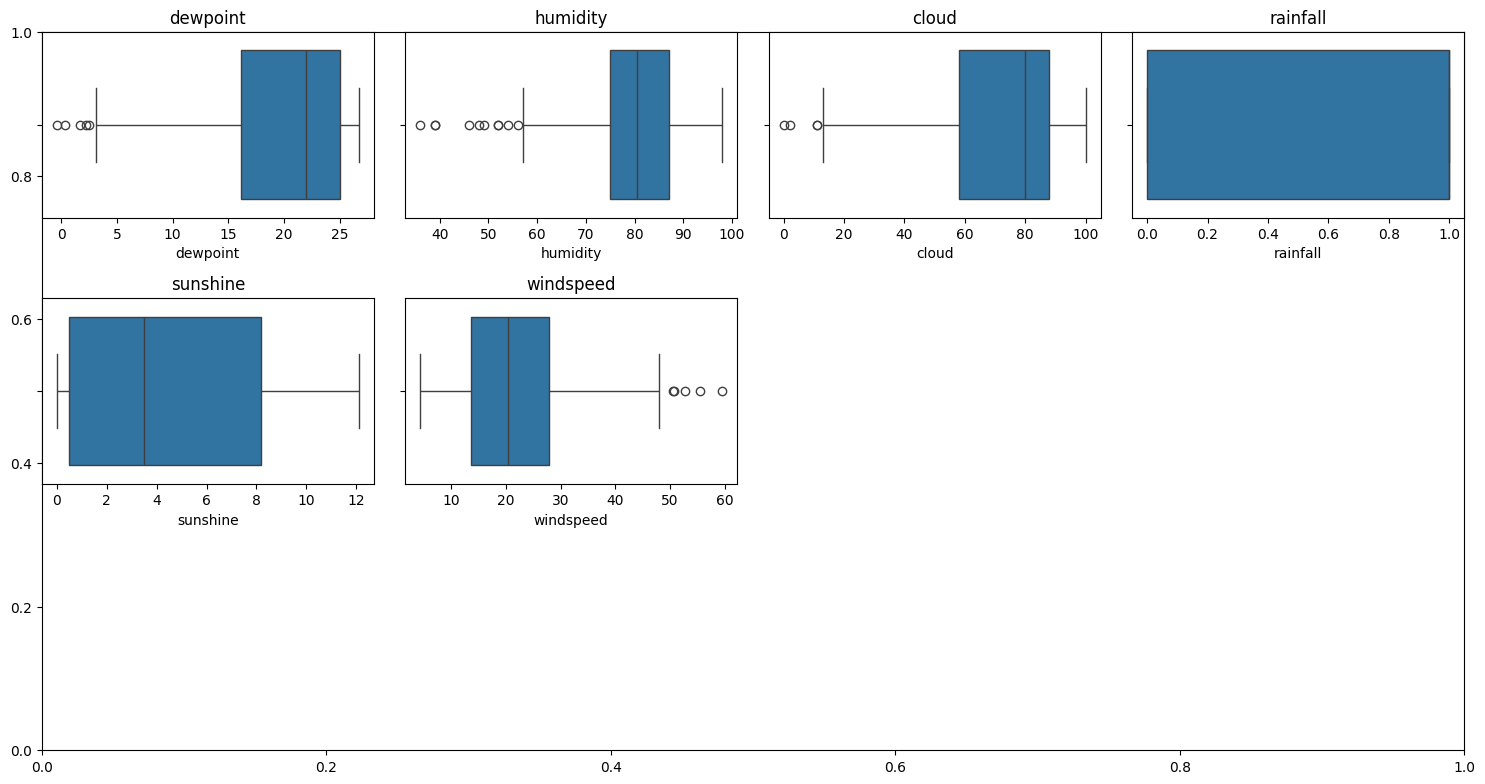

Training data size: (292, 5)
Testing data size: (74, 5)
Class distribution after resampling: rainfall
0    198
1    198
Name: count, dtype: int64


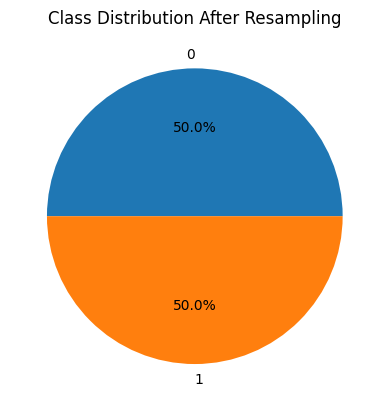

Training Accuracy (ROC AUC):  0.8999081726354453
Validation Accuracy (ROC AUC):  0.8158567774936062


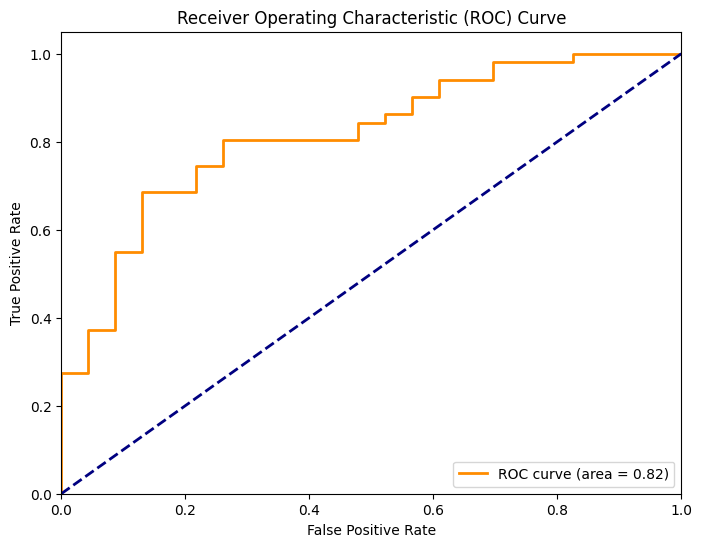

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


#import the dataset
file_path=r'E:\university\ML\rainfall-prediction-model\dataset\Rainfall.csv'
og_data=pd.read_csv(file_path)
#for displaying the first 5 rows of the data
og_data.head(5)

#see the shape and info
og_data.shape
og_data.info()

#data preprocessing:
# outliers removal, null value imputation,

og_data.isnull().sum()
#removing spaces in the column name
og_data.rename(str.strip,
          axis='columns', 
          inplace=True)

og_data.columns

#null value imputation
numerical_data = og_data.select_dtypes(include=['float64', 'int64'])
categorical_data = og_data.select_dtypes(include=['object'])
for col in numerical_data.columns:
    og_data[col]=og_data[col].fillna(og_data[col].mean())
for col in categorical_data.columns:
    og_data[col]=og_data[col].fillna(og_data[col].mode()[0])
print("the null values are:",og_data.isnull().sum().sum())

#encoding
lencoders = {}
for col in og_data.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    og_data[col] = lencoders[col].fit_transform(og_data[col])

#now visulize the data
plt.pie(og_data['rainfall'].value_counts().values,
        labels = og_data['rainfall'].value_counts().index,
        autopct='%1.1f%%')
plt.show()
og_data.groupby('rainfall').mean()

#from this pie chart we can see the data is unbalanced so we shall balance the classes but on the training data only

#correlation of the features with target var
correlation_matrix = og_data.corr()
target_correlation = correlation_matrix['rainfall'].sort_values(ascending=False)
print("Correlation with the target variable 'rainfall':")
print(target_correlation)

#removing features with low corealation with target var
target_correlation = correlation_matrix['rainfall'].sort_values(ascending=False)
low_corr_features = target_correlation[abs(target_correlation) < 0.1].index
og_data = og_data.drop(columns=low_corr_features)

og_data.info()

#heatmap
plt.figure(figsize=(10,10))
sb.heatmap(og_data.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()
#from the heat map we can decide to drop maxtemp
og_data.drop(['maxtemp'], axis=1, inplace=True)

# Visualize the distribution of each feature
plt.subplots(figsize=(15, 8))

# Loop through each column and plot its distribution
for i, col in enumerate(og_data.columns):
    plt.subplot(3, 4, i + 1)
    sb.histplot(og_data[col], kde=True)  # Using histplot with KDE for a better visualization
    plt.title(col)

plt.tight_layout()
plt.show()

#now outlier detection using box plot
plt.subplots(figsize=(15, 8))
for i, col in enumerate(og_data.columns):
    plt.subplot(3, 4, i + 1)  
    sb.boxplot(data=og_data, x=col)  
    plt.title(col) 

plt.tight_layout()
plt.show()

#would remove if there was more data



#model training

# Separate features and target
Features = og_data.drop(columns=['rainfall']) 
Target = og_data['rainfall']  

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, Y_train, Y_test = train_test_split(Features, Target, test_size=0.2, random_state=42)

# Verify the split
print("Training data size:", X_train.shape)
print("Testing data size:", X_test.shape)

# Balance the data using Random OverSampling
ros = RandomOverSampler(sampling_strategy='minority', random_state=22)
X_resampled, Y_resampled = ros.fit_resample(X_train, Y_train)

# Verify the class distribution after resampling
print(f"Class distribution after resampling: {Y_resampled.value_counts()}")
# Plot class distribution after resampling (pie chart)
plt.pie(Y_resampled.value_counts().values,
        labels = Y_resampled.value_counts().index,
        autopct='%1.1f%%')
plt.title('Class Distribution After Resampling')
plt.show()


# Feature normalization (scaling the data)
scaler = StandardScaler()

# Fit scaler on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_resampled)  # fit on resampled training data
X_test_scaled = scaler.transform(X_test)  # transform test data

# Train Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train_scaled, Y_resampled)

# Training predictions
train_preds = log_reg_model.predict_proba(X_train_scaled)
print('Training Accuracy (ROC AUC): ', metrics.roc_auc_score(Y_resampled, train_preds[:, 1]))

# Validation predictions
val_preds = log_reg_model.predict_proba(X_test_scaled)
print('Validation Accuracy (ROC AUC): ', metrics.roc_auc_score(Y_test, val_preds[:, 1]))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, val_preds[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()